In [1]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import random
from imutils import paths
import os
from keras.utils import to_categorical
from cnnmodel.similarvggnet import SmallerVGGNet
from keras import optimizers
from keras.preprocessing.image import img_to_array
import numpy as np
import shutil
from keras.preprocessing.image import ImageDataGenerator
import cv2

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [54]:
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('Dataset')))
random.seed(42)
random.shuffle(imagePaths)
print(imagePaths[:6])

[INFO] loading images...
['Dataset/Neutral/Neutral_325.jpg', 'Dataset/Sad/Sad_67.jpg', 'Dataset/Neutral/Neutral_175.jpg', 'Dataset/Sad/Sad_309.jpg', 'Dataset/Angry/Angry_269.jpg', 'Dataset/Afraid/Afraid_272.jpg']


In [55]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 128
w= 65 #you can change this in a multiple of 2
h= 43

# initialize the data and labels
data = []
labels = []

In [56]:

for imagePath in imagePaths:
    image = cv2.imread(imagePath,0)
    image = cv2.resize(image, (w,h))#resize image maintaining aspect ratio
#     b, g, r = cv2.split(image)
#     cv2.imshow('imgage',g)
#     cv2.waitkey(0)
#     key = cv2.waitKey()
#     cv2.destroyAllWindows()
    g = image
    image = img_to_array(g)
    data.append(image)
    label = imagePath.split(os.path.sep)[-1].split('_')[0]
    if label == 'Angry':
        label = 0
    elif label == 'Disgusted':
        label = 1
    elif label == 'Afraid':
        label = 2
    elif label == 'Sad':
        label = 3
    elif label == 'Happy':
        label = 4
    elif label == 'Neutral':
        label = 5
    else:
        label = 6
    
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [57]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [58]:
trainY = to_categorical(trainY, num_classes=7)
testY = to_categorical(testY, num_classes=7)

In [99]:
aug = ImageDataGenerator(zca_whitening=True,fill_mode="nearest")

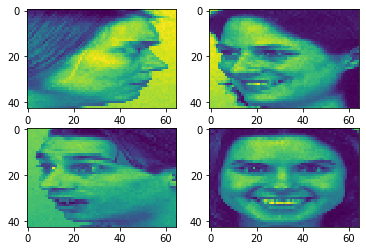

In [100]:
#Saving and displaying augmented images
for X_batch, y_batch in aug.flow(trainX, trainY, batch_size=len(trainX)):
    # create a grid of 2x2 images
    for i in range(0, 4):
        plt.subplot(220 + 1 + i)
        plt.imshow(X_batch[i].reshape(43,65))
    # show the plot
    plt.show()
    break

In [31]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# test_datagen = ImageDataGenerator(rescale = 1./255)

# training_set = train_datagen.flow_from_directory('Dataset/training_set',
#                                                  target_size = (64, 64),
#                                                  batch_size = 32,
#                                                  class_mode = 'binary')

# test_set = test_datagen.flow_from_directory('Dataset/test_set',
#                                             target_size = (64, 64),
#                                             batch_size = 32,
#                                             class_mode = 'binary')

In [32]:
# for X_batch, y_batch in train_datagen.flow_from_directory('Dataset/training_set', batch_size=50, save_format='png'):
#     # create a grid of 2x2 images
#     for i in range(0, 4):
#         plt.subplot(220 + 1 + i)
#         plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
#     # show the plot
#     plt.show()
#     break

In [103]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (h, w, 1), activation = 'relu'))
classifier.add(Convolution2D(32, 3, 3, activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Convolution2D(64, 3, 3, activation = 'relu'))
classifier.add(Convolution2D(64, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding third convolutional layer
classifier.add(Convolution2D(128, 3, 3, activation = 'relu'))
classifier.add(Convolution2D(128, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(output_dim = 1024, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(output_dim = 7, activation = 'softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 41, 63, 32)        320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 39, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 19, 30, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 17, 28, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 13, 64)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 5, 11, 128)        73856     
__________

/home/saksham.goyal.16csc/anaconda3/envs/ED/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(43, 65, 1..., activation="relu")`
  """
/home/saksham.goyal.16csc/anaconda3/envs/ED/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/home/saksham.goyal.16csc/anaconda3/envs/ED/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if sys.path[0] == '':
/home/saksham.goyal.16csc/anaconda3/envs/ED/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  del sys.path[0]
/home/saksham.goyal.16csc/anaconda3/envs/ED/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call

In [105]:
H = classifier.fit_generator(aug.flow(trainX, trainY ,batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1, callbacks=[es]) 

Epoch 1/50
14/14 [==============================] - 5s 330ms/step - loss: 0.4101 - acc: 0.8571 - val_loss: 0.4104 - val_acc: 0.8571
Epoch 2/50
14/14 [==============================] - 5s 324ms/step - loss: 0.4102 - acc: 0.8571 - val_loss: 0.4104 - val_acc: 0.8571
Epoch 3/50
14/14 [==============================] - 5s 335ms/step - loss: 0.4100 - acc: 0.8571 - val_loss: 0.4102 - val_acc: 0.8571
Epoch 4/50
14/14 [==============================] - 4s 314ms/step - loss: 0.4076 - acc: 0.8571 - val_loss: 0.3969 - val_acc: 0.8571
Epoch 5/50
14/14 [==============================] - 5s 336ms/step - loss: 0.3893 - acc: 0.8571 - val_loss: 0.3824 - val_acc: 0.8571
Epoch 6/50
14/14 [==============================] - 5s 327ms/step - loss: 0.3718 - acc: 0.8567 - val_loss: 0.3663 - val_acc: 0.8616
Epoch 7/50
14/14 [==============================] - 4s 318ms/step - loss: 0.3577 - acc: 0.8606 - val_loss: 0.3504 - val_acc: 0.8637
Epoch 8/50
14/14 [==============================] - 5s 332ms/step - loss: 0.

In [66]:
classifier.save('model.h5')

In [91]:
image = cv2.imread('test4.jpg',0)
orig = image.copy()
image = cv2.resize(image, (w,h))#resize image maintaining aspect ratio

In [92]:
#image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [93]:
cat = ['Angry','Disgusted','Afraid','Sad','Happy','Neutral','Suprised']
arr = classifier.predict(image)[0]
print(arr)
res = np.amax(arr)
cat[np.where(arr == res)[0][0]]

[0.00052701 0.00060927 0.49519727 0.37063158 0.00055164 0.1271606
 0.00532267]


'Afraid'

## VGG NET

In [39]:
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=w, height=h, depth=3, classes=7)

sgd = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer= sgd, metrics=['accuracy'])


#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#model.compile(loss="binary_crossentropy", optimizer=opt,
#	metrics=["accuracy"])
print(model.summary())

[INFO] compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 43, 65, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 43, 65, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 65, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 43, 65, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 43, 65, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 43, 65, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 32, 32)   

In [40]:
print("[INFO] training network...")
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1, callbacks=[es])

# save the model to disk
print("[INFO] serializing network...")

[INFO] training network...
Epoch 1/50


/home/saksham.goyal.16csc/anaconda3/envs/ED/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/saksham.goyal.16csc/anaconda3/envs/ED/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


14/14 [==============================] - 30s 2s/step - loss: 0.6375 - acc: 0.7980 - val_loss: 0.4292 - val_acc: 0.8564
Epoch 2/50
14/14 [==============================] - 26s 2s/step - loss: 0.6100 - acc: 0.8032 - val_loss: 0.4449 - val_acc: 0.8550
Epoch 3/50
14/14 [==============================] - 27s 2s/step - loss: 0.5840 - acc: 0.8073 - val_loss: 0.4504 - val_acc: 0.8536
Epoch 4/50
14/14 [==============================] - 27s 2s/step - loss: 0.5530 - acc: 0.8169 - val_loss: 0.4341 - val_acc: 0.8543
Epoch 5/50
14/14 [==============================] - 28s 2s/step - loss: 0.5384 - acc: 0.8210 - val_loss: 0.3983 - val_acc: 0.8651
Epoch 6/50
14/14 [==============================] - 26s 2s/step - loss: 0.5128 - acc: 0.8267 - val_loss: 0.3899 - val_acc: 0.8672
Epoch 7/50
14/14 [==============================] - 28s 2s/step - loss: 0.5118 - acc: 0.8276 - val_loss: 0.3716 - val_acc: 0.8716
Epoch 8/50
14/14 [==============================] - 27s 2s/step - loss: 0.5035 - acc: 0.8353 - val_lo

In [41]:
# save the model to disk
print("[INFO] serializing network...")
model.save('VGGModel.h5')

[INFO] serializing network...


In [53]:
image = cv2.imread('Dataset/Angry/Angry_5.jpg')
orig = image.copy()
image = cv2.resize(image, (w,h))#resize image maintaining aspect ratio
#image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
cat = ['Angry','Disgusted','Afraid','Sad','Happy','Neutral','Suprised']
arr = model.predict(image)[0]
print(arr)
res = np.amax(arr)
cat[np.where(arr == res)[0][0]]

[0.162668   0.2038128  0.25004035 0.00228082 0.10788493 0.17629266
 0.09702041]


'Afraid'